# Rainfall and temperature data 

In this example, we are using CHRIPS rainfall dataset and MODIS surface temperature

* Tutorial: https://www.youtube.com/watch?v=hsJxeecHqeM&list=WL&index=38

## Workflow

 * Instalation of libraries
 * Select the image collections
 * Define the time series of data
 * Graphics and interpretation of the results

## Instalation of libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json
import ee

%matplotlib inline
# %matplotlib.qt

import seaborn as sns
from ipygee import *
import altair as alt

In [3]:
# Start the earth engine library
ee.Initialize()

## Select the image collections

### Select the area of interest (AOI)

In [4]:
# Define the location of interest as a point near Guadalajara, MEX
p_lon = -103.364086
p_lat = 20.674770
point = ee.Geometry.Point(p_lon, p_lat)

In [5]:
# Define time range
startyear = 2001
endyear = 2020

# Set the date in ee date format
start_date = ee.Date.fromYMD(startyear, 1, 1)
end_date = ee.Date.fromYMD(endyear, 12, 31)

# Create a list of years
years = range(startyear, endyear + 1)

# Create a list of months
months = range(1, 13)

In [6]:
print(years)
print(months)

range(2001, 2021)
range(1, 13)


### CHIRPS Collection - Rainfall 

In [7]:
# Import CHIRPS dataset
CHIRPS = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
    .select('precipitation')\
    .filterDate(start_date, end_date)\
    .filterBounds(point)

In [8]:
# Define a list of dates
dates_chirps = CHIRPS.aggregate_array('system:time_start').map(lambda d: ee.Date(d).format('YYYY-MM-dd'))
print(dates_chirps.getInfo())

['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10', '2001-01-11', '2001-01-12', '2001-01-13', '2001-01-14', '2001-01-15', '2001-01-16', '2001-01-17', '2001-01-18', '2001-01-19', '2001-01-20', '2001-01-21', '2001-01-22', '2001-01-23', '2001-01-24', '2001-01-25', '2001-01-26', '2001-01-27', '2001-01-28', '2001-01-29', '2001-01-30', '2001-01-31', '2001-02-01', '2001-02-02', '2001-02-03', '2001-02-04', '2001-02-05', '2001-02-06', '2001-02-07', '2001-02-08', '2001-02-09', '2001-02-10', '2001-02-11', '2001-02-12', '2001-02-13', '2001-02-14', '2001-02-15', '2001-02-16', '2001-02-17', '2001-02-18', '2001-02-19', '2001-02-20', '2001-02-21', '2001-02-22', '2001-02-23', '2001-02-24', '2001-02-25', '2001-02-26', '2001-02-27', '2001-02-28', '2001-03-01', '2001-03-02', '2001-03-03', '2001-03-04', '2001-03-05', '2001-03-06', '2001-03-07', '2001-03-08', '2001-03-09', '2001-03-10', '2001-03-11', '2001-03-12', '2001

In [9]:
def date (image):
    return image.clip(point).copyProperties(image, ["system:time_start"]).set('date', image.date().format('YYYY-MM-dd'))

CHIRPS = CHIRPS.map(date)
CHIRPS.first().propertyNames().getInfo()

['date',
 'system:footprint',
 'system:time_start',
 'system:time_end',
 'system:version',
 'system:id',
 'system:asset_size',
 'system:index',
 'system:bands',
 'system:band_names']

In [10]:
# Calculate the monthly median

def Monthlysum (imageCollection):
    mylist = ee.List([])
    for y in years:
        for m in months:
            w = imageCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum()
            mylist = mylist.add(w.set('year', y)\
                                .set('month', m)\
                                .set('date', ee.Date.fromYMD(y, m, 1))\
                                .set('system:time_start', ee.Date.fromYMD(y, m, 1)))

    return ee.ImageCollection.fromImages(mylist).set('date', ee.Date.fromYMD(y, m, 1))\
                                
# apply the function
monthlychirps = ee.ImageCollection(Monthlysum(CHIRPS))
print(monthlychirps.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'precipitation', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'date': {'type': 'Date', 'value': 978307200000}, 'system:time_start': {'type': 'Date', 'value': 978307200000}, 'month': 1, 'year': 2001, 'system:index': '0'}}


In [11]:
print(monthlychirps.first().propertyNames().getInfo())

['date', 'system:time_start', 'month', 'year', 'system:index', 'system:bands', 'system:band_names']


In [12]:
# Reduce the rainfall data to daily data
def reduce (image):
    series_reduce = image.reduceRegions(**{
        'collection': point,
        'reducer': ee.Reducer.mean().combine(**{
            'reducer2': ee.Reducer.min(),
            'sharedInputs': True}).combine(**{
            'reducer2': ee.Reducer.max(),
            'sharedInputs': True}),
        'scale': 1000
    })
    
    series_reduce = series_reduce.map(lambda f: f.set({'millis': image.get('millis')}))\
                                 .map(lambda f: f.set({'date': image.get('date')}))\
                                 .map(lambda f: f.set({'month': image.get('month')}))\
                                 .map(lambda f: f.set({'year': image.get('year')}))
    
    return series_reduce.copyProperties(image, ['system:time_start'])

# Apply 'Reduce' function
precipitation_reduction = monthlychirps.map(reduce)\
    .flatten()\
    .sort('date', True)\
    .select(['millis', 'date', 'min', 'mean', 'max', 'month', 'year'])

# Show the results
print(precipitation_reduction.size().getInfo())

240


In [13]:
precipitation_reduction.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-103.364086, 20.67477]},
 'id': '0_0',
 'properties': {'date': {'type': 'Date', 'value': 978307200000},
  'max': 7.913122892379761,
  'mean': 7.913122892379761,
  'min': 7.913122892379761,
  'month': 1,
  'year': 2001}}

In [14]:
# establish the list of data
precipitation_list = precipitation_reduction\
    .reduceColumns(ee.Reducer.toList(6), ['date', 'min', 'mean', 'max', 'month', 'year']).values().get(0)

In [15]:
# Use pandas to convert the list to a dataframe
df_precipitation = pd.DataFrame(precipitation_list.getInfo(), columns=['date','rainfall_min','rainfall_mean','rainfall_max','month','year'])
df_precipitation

date  rainfall_min  rainfall_mean  \
0     {'type': 'Date', 'value': 978307200000}      7.913123       7.913123   
1     {'type': 'Date', 'value': 980985600000}      5.112167       5.112167   
2     {'type': 'Date', 'value': 983404800000}      4.682935       4.682935   
3     {'type': 'Date', 'value': 986083200000}      4.099176       4.099176   
4     {'type': 'Date', 'value': 988675200000}     30.752923      30.752923   
..                                        ...           ...            ...   
235  {'type': 'Date', 'value': 1596240000000}    192.192056     192.192056   
236  {'type': 'Date', 'value': 1598918400000}    128.819105     128.819105   
237  {'type': 'Date', 'value': 1601510400000}     28.254692      28.254692   
238  {'type': 'Date', 'value': 1604188800000}      0.000000       0.000000   
239  {'type': 'Date', 'value': 1606780800000}      0.000000       0.000000   

     rainfall_max  month  year  
0        7.913123      1  2001  
1        5.112167      2  2001  
2        4.682935      3  2001  
3        4.099176      4  2001  
4       30.752923      5  2001  
..            ...    ...   ...  
235    192.192056      8  2020  
236    128.819105      9  2020  
237     28.254692     10  2020  
238      0.000000     11  2020  
239      0.000000     12  2020  

[240 rows x 6 columns]

In [16]:
# Export the table to csv

# directory route
fp = 'C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\climogram\\rainfall_table.csv'

export_rainfall = df_precipitation.to_csv(fp)

In [17]:
# Read .csv data
df_preci = pd.read_csv('C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\climogram\\rainfall_table.csv')
df_preci

Unnamed: 0                                      date  rainfall_min  \
0             0   {'type': 'Date', 'value': 978307200000}      7.913123   
1             1   {'type': 'Date', 'value': 980985600000}      5.112167   
2             2   {'type': 'Date', 'value': 983404800000}      4.682935   
3             3   {'type': 'Date', 'value': 986083200000}      4.099176   
4             4   {'type': 'Date', 'value': 988675200000}     30.752923   
..          ...                                       ...           ...   
235         235  {'type': 'Date', 'value': 1596240000000}    192.192056   
236         236  {'type': 'Date', 'value': 1598918400000}    128.819105   
237         237  {'type': 'Date', 'value': 1601510400000}     28.254692   
238         238  {'type': 'Date', 'value': 1604188800000}      0.000000   
239         239  {'type': 'Date', 'value': 1606780800000}      0.000000   

     rainfall_mean  rainfall_max  month  year  
0         7.913123      7.913123      1  2001  
1         5.112167      5.112167      2  2001  
2         4.682935      4.682935      3  2001  
3         4.099176      4.099176      4  2001  
4        30.752923     30.752923      5  2001  
..             ...           ...    ...   ...  
235     192.192056    192.192056      8  2020  
236     128.819105    128.819105      9  2020  
237      28.254692     28.254692     10  2020  
238       0.000000      0.000000     11  2020  
239       0.000000      0.000000     12  2020  

[240 rows x 7 columns]

### Create a plot

Text(0.5, 1.0, 'Median rainfall of Guadalajara city from 2001 to 2020')

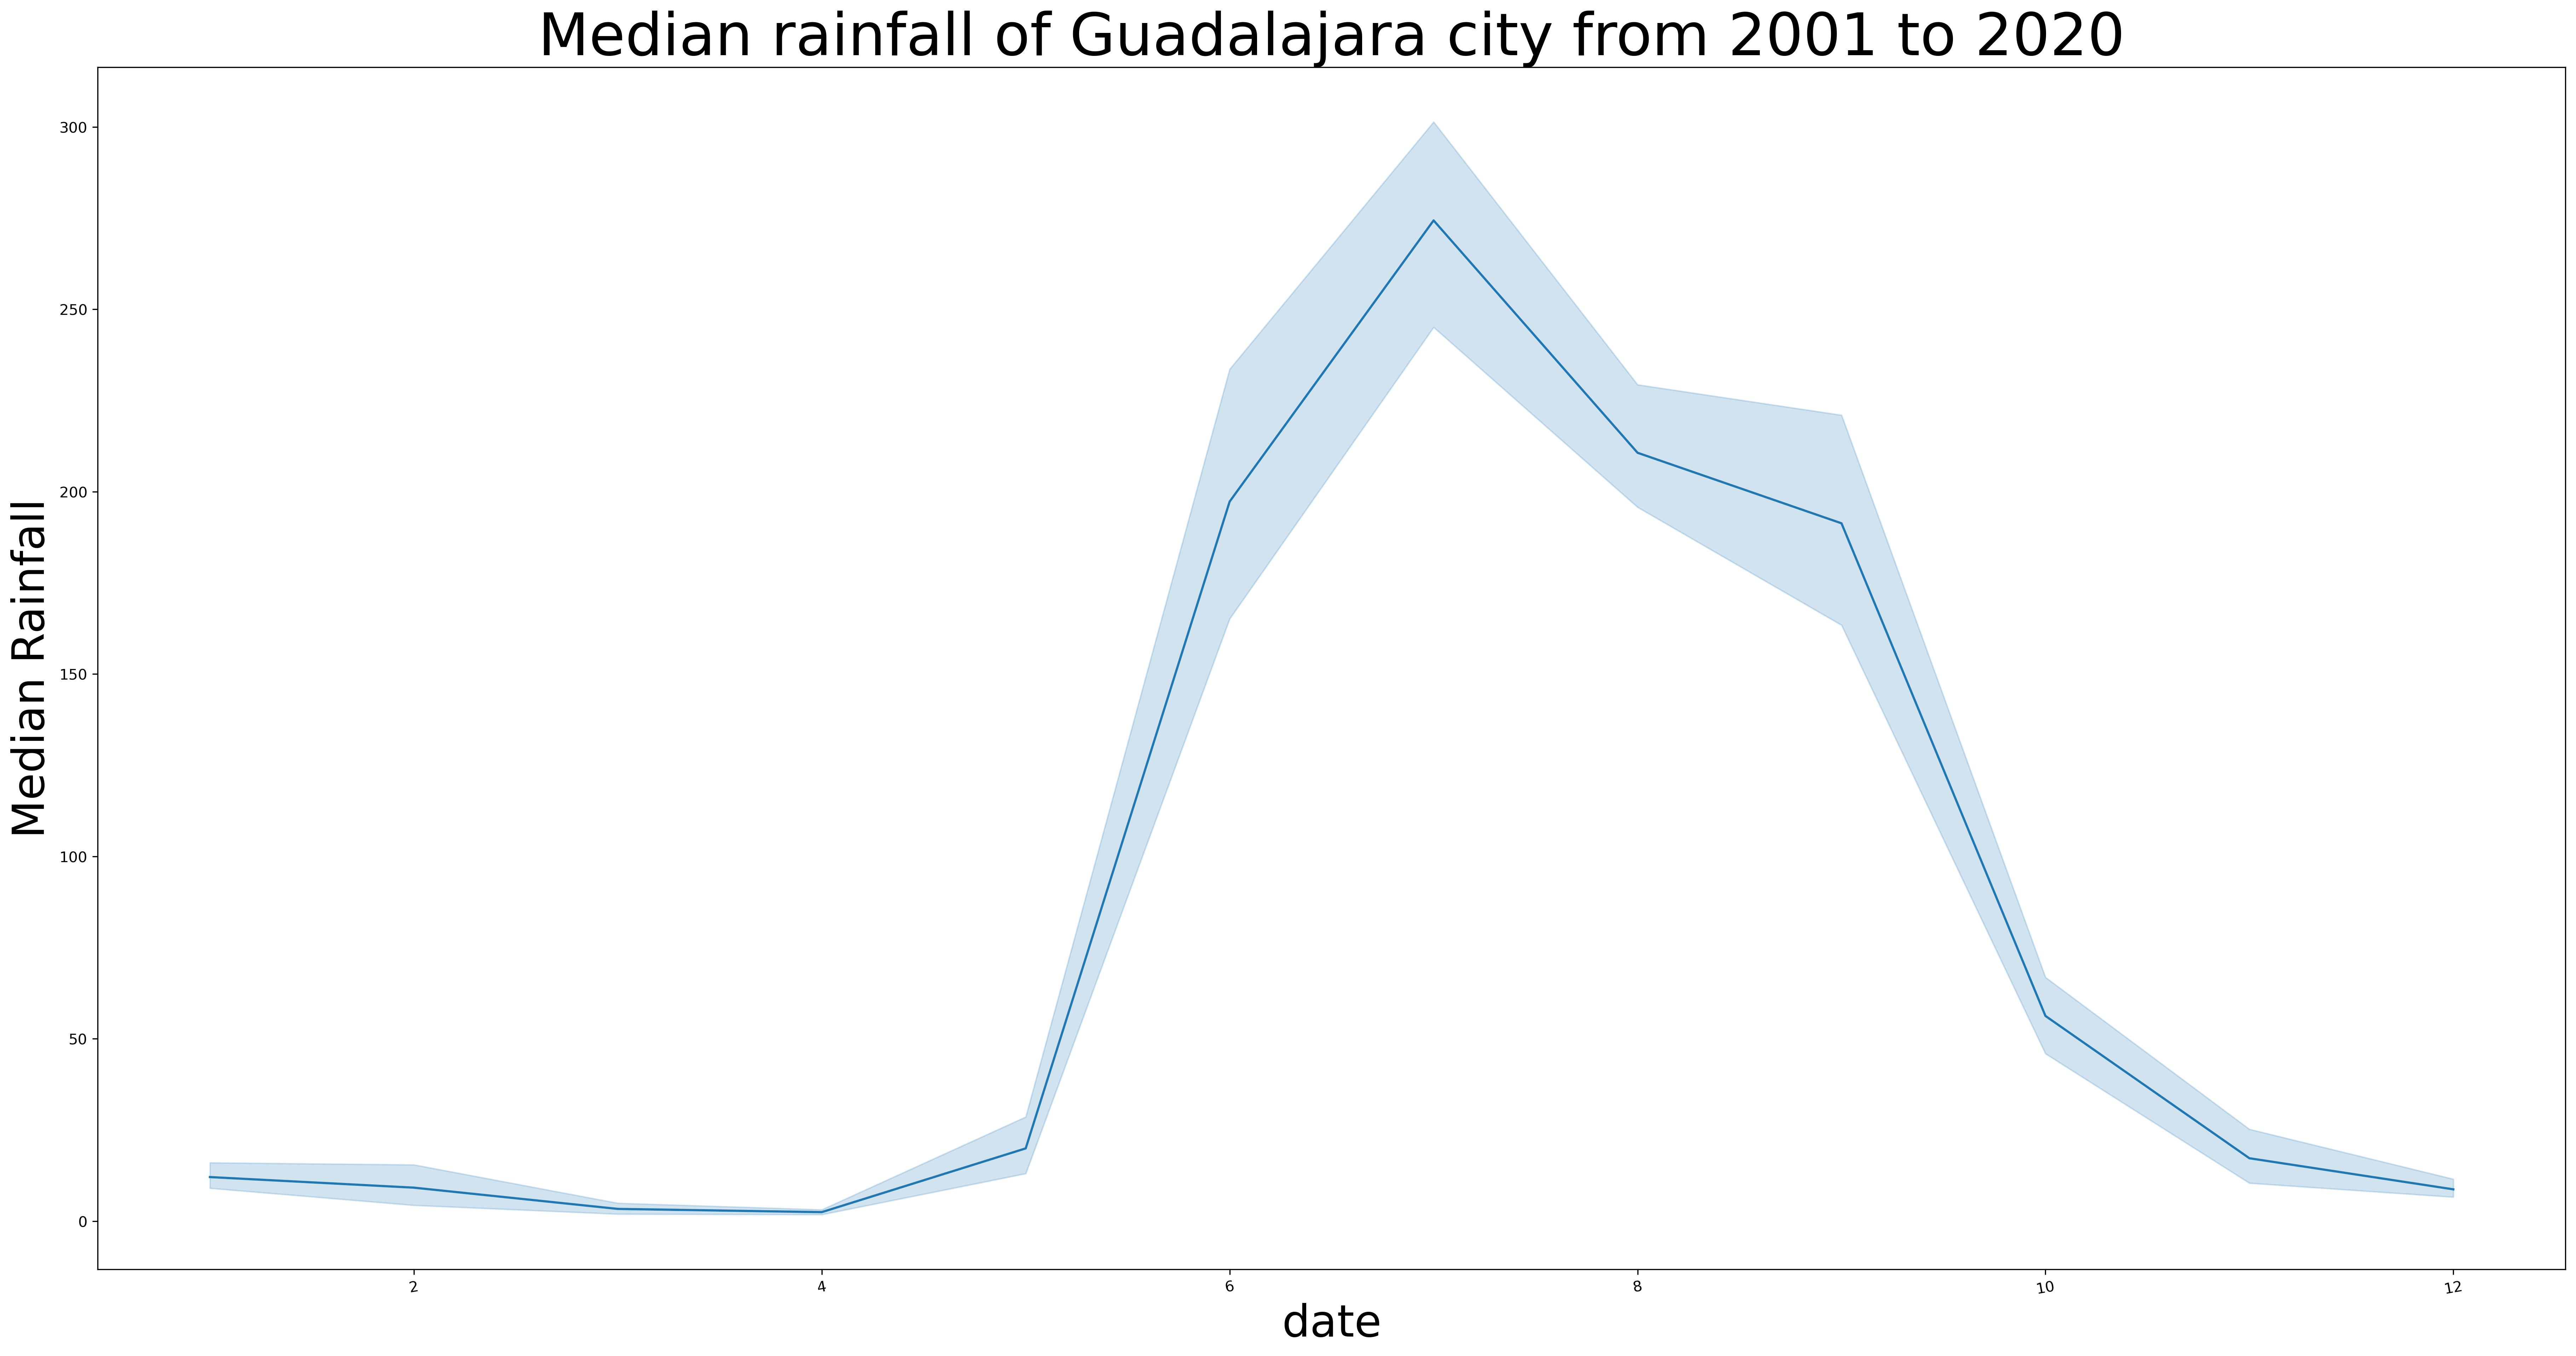

In [18]:
# Create a plot with the dataframe
fig, ax = plt.subplots(1,1,figsize=(30, 15),dpi=300)

# Use 'rainfall_mean' and 'month' to create a plot
sns.lineplot(data = df_preci, x = 'month', y = 'rainfall_mean')

# plot tiles
ax.set_ylabel('Median Rainfall', fontsize = 30)
ax.set_xlabel('date', fontsize = 30)
plt.xticks(rotation = 10)
ax.set_title('Median rainfall of Guadalajara city from 2001 to 2020', fontsize = 40)

In [19]:
# Calculate the monthly median precipitation 
precipitation_month = df_preci.groupby(['month']) ['rainfall_mean'].mean()
precipitation_month

month
1      12.064812
2       9.163358
3       3.336717
4       2.449057
5      19.930593
6     197.298424
7     274.385585
8     210.672729
9     191.332132
10     56.251519
11     17.227574
12      8.702774
Name: rainfall_mean, dtype: float64

## MODIS Collection: Temperature

In [20]:
# Import temperature collection
MODIS = ee.ImageCollection("MODIS/006/MOD11A1")\
    .select('LST_Day_1km')\
    .filterDate(start_date, end_date)\
    .filterBounds(point)

# Temperature function
def temp (img):
    return img.select('LST_Day_1km').multiply(0.02).subtract(273.15).rename('LST').copyProperties(img, ["system:time_start"])

MODIS = MODIS.map(temp)

In [21]:
dates_MODIS = MODIS.aggregate_array('system:time_start').map(lambda d: ee.Date(d).format('YYYY-MM-dd'))
print(dates_MODIS.getInfo())

['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10', '2001-01-11', '2001-01-12', '2001-01-13', '2001-01-14', '2001-01-15', '2001-01-16', '2001-01-17', '2001-01-18', '2001-01-19', '2001-01-20', '2001-01-21', '2001-01-22', '2001-01-23', '2001-01-24', '2001-01-25', '2001-01-26', '2001-01-27', '2001-01-28', '2001-01-29', '2001-01-30', '2001-01-31', '2001-02-01', '2001-02-02', '2001-02-03', '2001-02-04', '2001-02-05', '2001-02-06', '2001-02-07', '2001-02-08', '2001-02-09', '2001-02-10', '2001-02-11', '2001-02-12', '2001-02-13', '2001-02-14', '2001-02-15', '2001-02-16', '2001-02-17', '2001-02-18', '2001-02-19', '2001-02-20', '2001-02-21', '2001-02-22', '2001-02-23', '2001-02-24', '2001-02-25', '2001-02-26', '2001-02-27', '2001-02-28', '2001-03-01', '2001-03-02', '2001-03-03', '2001-03-04', '2001-03-05', '2001-03-06', '2001-03-07', '2001-03-08', '2001-03-09', '2001-03-10', '2001-03-11', '2001-03-12', '2001

In [22]:
# date function
def date (image):
    return image.clip(point).copyProperties(image, ["system:time_start"]).set('date', image.date().format('YYYY-MM-dd'))

# Appy the function
MODIS = MODIS.map(date)
MODIS.first().propertyNames().getInfo()

['system:time_start',
 'date',
 'system:footprint',
 'system:index',
 'system:bands',
 'system:band_names']

In [23]:
# Calculate the monthly mean

def Monthlymean (imageCollection):
    mylist = ee.List([])
    for y in years:
        for m in months:
            w = imageCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).mean()
            mylist = mylist.add(w.set('year', y)\
                                .set('month', m)\
                                .set('date', ee.Date.fromYMD(y, m, 1))\
                                .set('system:time_start', ee.Date.fromYMD(y, m, 1)))

    return ee.ImageCollection.fromImages(mylist).set('date', ee.Date.fromYMD(y, m, 1))\
                                
# Apply the function
monthlyMODIS = Monthlymean(MODIS)
print(monthlyMODIS.getInfo())

{'type': 'ImageCollection', 'bands': [], 'properties': {'date': {'type': 'Date', 'value': 1606780800000}}, 'features': [{'type': 'Image', 'bands': [{'id': 'LST', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -273.15, 'max': 1037.5500000000002}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'date': {'type': 'Date', 'value': 978307200000}, 'system:time_start': {'type': 'Date', 'value': 978307200000}, 'month': 1, 'year': 2001, 'system:index': '0'}}, {'type': 'Image', 'bands': [{'id': 'LST', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -273.15, 'max': 1037.5500000000002}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'date': {'type': 'Date', 'value': 980985600000}, 'system:time_start': {'type': 'Date', 'value': 980985600000}, 'month': 2, 'year': 2001, 'system:index': '1'}}, {'type': 'Image', 'bands': [{'id': 'LST', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -273.15, 'max': 1

In [24]:
print(monthlyMODIS.first().propertyNames().getInfo())

['date', 'system:time_start', 'month', 'year', 'system:index', 'system:bands', 'system:band_names']


In [25]:
# Reduce the temperature data to daily data
def reduce (image):
    series_reduce = image.reduceRegions(**{
        'collection': point,
        'reducer': ee.Reducer.mean().combine(**{
            'reducer2': ee.Reducer.min(),
            'sharedInputs': True}).combine(**{
            'reducer2': ee.Reducer.max(),
            'sharedInputs': True}),
        'scale': 1000,
    })
    
    series_reduce = series_reduce.map(lambda f: f.set({'millis': image.get('millis')}))\
                                 .map(lambda f: f.set({'date': image.get('date')}))\
                                 .map(lambda f: f.set({'month': image.get('month')}))\
                                 .map(lambda f: f.set({'year': image.get('year')}))
    
    return series_reduce.copyProperties(image, ['system:time_start'])

# Apply 'Reduce' function
temperature_reduction = monthlyMODIS.map(reduce)\
    .flatten()\
    .sort('date', True)\
    .select(['millis','date', 'min', 'mean', 'max', 'month', 'year'])

# Show the results
print(temperature_reduction.size().getInfo())

240


In [26]:
# establish the list of data
temperature_list = temperature_reduction\
    .reduceColumns(ee.Reducer.toList(6), ['date', 'min', 'mean', 'max', 'month', 'year']).values().get(0)

In [27]:
# Use pandas to convert the list to a dataframe
df_temperatura = pd.DataFrame(temperature_list.getInfo(), columns=['date','LST_min','LST_mean','LST_max','month','year'])
df_temperatura

# 'LST_min and 'LST_max could be obtained if we are using a polygon. in this case we are using a point

date    LST_min   LST_mean  \
0     {'type': 'Date', 'value': 978307200000}  27.812500  27.812500   
1     {'type': 'Date', 'value': 980985600000}  32.089000  32.089000   
2     {'type': 'Date', 'value': 983404800000}  38.101818  38.101818   
3     {'type': 'Date', 'value': 986083200000}  42.083913  42.083913   
4     {'type': 'Date', 'value': 988675200000}  41.553158  41.553158   
..                                        ...        ...        ...   
234  {'type': 'Date', 'value': 1596240000000}  36.060000  36.060000   
235  {'type': 'Date', 'value': 1598918400000}  32.605000  32.605000   
236  {'type': 'Date', 'value': 1601510400000}  34.452727  34.452727   
237  {'type': 'Date', 'value': 1604188800000}  32.178148  32.178148   
238  {'type': 'Date', 'value': 1606780800000}  27.784737  27.784737   

       LST_max  month  year  
0    27.812500      1  2001  
1    32.089000      2  2001  
2    38.101818      3  2001  
3    42.083913      4  2001  
4    41.553158      5  2001  
..         ...    ...   ...  
234  36.060000      8  2020  
235  32.605000      9  2020  
236  34.452727     10  2020  
237  32.178148     11  2020  
238  27.784737     12  2020  

[239 rows x 6 columns]

In [28]:
# Export the table to csv

# directory route
fp = 'C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\climogram\\temperature_table.csv'

export_temperature = df_temperatura.to_csv(fp)

In [29]:
# Read .csv data
df_temp = pd.read_csv('C:\\Users\\Juan Alexis\\Documents\\QUANTUN\\climogram\\temperature_table.csv')
df_temp

Unnamed: 0                                      date    LST_min  \
0             0   {'type': 'Date', 'value': 978307200000}  27.812500   
1             1   {'type': 'Date', 'value': 980985600000}  32.089000   
2             2   {'type': 'Date', 'value': 983404800000}  38.101818   
3             3   {'type': 'Date', 'value': 986083200000}  42.083913   
4             4   {'type': 'Date', 'value': 988675200000}  41.553158   
..          ...                                       ...        ...   
234         234  {'type': 'Date', 'value': 1596240000000}  36.060000   
235         235  {'type': 'Date', 'value': 1598918400000}  32.605000   
236         236  {'type': 'Date', 'value': 1601510400000}  34.452727   
237         237  {'type': 'Date', 'value': 1604188800000}  32.178148   
238         238  {'type': 'Date', 'value': 1606780800000}  27.784737   

      LST_mean    LST_max  month  year  
0    27.812500  27.812500      1  2001  
1    32.089000  32.089000      2  2001  
2    38.101818  38.101818      3  2001  
3    42.083913  42.083913      4  2001  
4    41.553158  41.553158      5  2001  
..         ...        ...    ...   ...  
234  36.060000  36.060000      8  2020  
235  32.605000  32.605000      9  2020  
236  34.452727  34.452727     10  2020  
237  32.178148  32.178148     11  2020  
238  27.784737  27.784737     12  2020  

[239 rows x 7 columns]

### Create a plot

In [30]:
# Create a plot with the dataframe
fig, ax = plt.subplots(1,1,figsize=(30, 15),dpi=600)

# Use 'rainfall_mean' and 'month' to create a plot
sns.lineplot(data = df_temp, x = 'month', y = 'LST_mean')

# plot tiles
ax.set_ylabel('Median LST', fontsize = 30)
ax.set_xlabel('date', fontsize = 30)
plt.xticks(rotation = 10)
ax.set_title('Median Land Surface Temperature of Guadalajara city from 2001 to 2020', fontsize = 40)

Text(0.5, 1.0, 'Median Land Surface Temperature of Guadalajara city from 2001 to 2020')

In [31]:
# Calculate the monthly median LST 
LST_month = df_temp.groupby(['month']) ['LST_mean', 'LST_min', 'LST_max'].mean()
LST_month

C:\Users\JUANAL~1\AppData\Local\Temp/ipykernel_2592/4185834679.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  LST_month = df_temp.groupby(['month']) ['LST_mean', 'LST_min', 'LST_max'].mean()


LST_mean    LST_min    LST_max
month                                 
1      27.772252  27.772252  27.772252
2      31.695570  31.695570  31.695570
3      37.656962  37.656962  37.656962
4      42.055328  42.055328  42.055328
5      42.755012  42.755012  42.755012
6      38.409020  38.409020  38.409020
7      34.534713  34.534713  34.534713
8      35.158873  35.158873  35.158873
9      34.351941  34.351941  34.351941
10     33.041966  33.041966  33.041966
11     30.601919  30.601919  30.601919
12     27.668669  27.668669  27.668669

# Climogram

In [32]:
# join both dataframes
data_join = pd.merge(df_preci, df_temp, on = 'month')
data_join

Unnamed: 0_x                                    date_x  rainfall_min  \
0                0   {'type': 'Date', 'value': 978307200000}      7.913123   
1                0   {'type': 'Date', 'value': 978307200000}      7.913123   
2                0   {'type': 'Date', 'value': 978307200000}      7.913123   
3                0   {'type': 'Date', 'value': 978307200000}      7.913123   
4                0   {'type': 'Date', 'value': 978307200000}      7.913123   
...            ...                                       ...           ...   
4775           239  {'type': 'Date', 'value': 1606780800000}      0.000000   
4776           239  {'type': 'Date', 'value': 1606780800000}      0.000000   
4777           239  {'type': 'Date', 'value': 1606780800000}      0.000000   
4778           239  {'type': 'Date', 'value': 1606780800000}      0.000000   
4779           239  {'type': 'Date', 'value': 1606780800000}      0.000000   

      rainfall_mean  rainfall_max  month  year_x  Unnamed: 0_y  \
0          7.913123      7.913123      1    2001             0   
1          7.913123      7.913123      1    2001            12   
2          7.913123      7.913123      1    2001            24   
3          7.913123      7.913123      1    2001            35   
4          7.913123      7.913123      1    2001            47   
...             ...           ...    ...     ...           ...   
4775       0.000000      0.000000     12    2020           190   
4776       0.000000      0.000000     12    2020           202   
4777       0.000000      0.000000     12    2020           214   
4778       0.000000      0.000000     12    2020           226   
4779       0.000000      0.000000     12    2020           238   

                                        date_y    LST_min   LST_mean  \
0      {'type': 'Date', 'value': 978307200000}  27.812500  27.812500   
1     {'type': 'Date', 'value': 1009843200000}  28.610000  28.610000   
2     {'type': 'Date', 'value': 1041379200000}  27.291111  27.291111   
3     {'type': 'Date', 'value': 1072915200000}  26.112667  26.112667   
4     {'type': 'Date', 'value': 1104537600000}  28.004286  28.004286   
...                                        ...        ...        ...   
4775  {'type': 'Date', 'value': 1480550400000}  28.195217  28.195217   
4776  {'type': 'Date', 'value': 1512086400000}  27.690000  27.690000   
4777  {'type': 'Date', 'value': 1543622400000}  26.052105  26.052105   
4778  {'type': 'Date', 'value': 1575158400000}  28.494167  28.494167   
4779  {'type': 'Date', 'value': 1606780800000}  27.784737  27.784737   

        LST_max  year_y  
0     27.812500    2001  
1     28.610000    2002  
2     27.291111    2003  
3     26.112667    2004  
4     28.004286    2005  
...         ...     ...  
4775  28.195217    2016  
4776  27.690000    2017  
4777  26.052105    2018  
4778  28.494167    2019  
4779  27.784737    2020  

[4780 rows x 13 columns]

In [33]:
df_temp_preci = pd.merge(
    precipitation_month, LST_month, how = 'left', on = 'month').reset_index()
    
df_temp_preci = df_temp_preci[['month', 'LST_min', 'LST_max', 'LST_mean', 'rainfall_mean']]

df_temp_preci

month    LST_min    LST_max   LST_mean  rainfall_mean
0       1  27.772252  27.772252  27.772252      12.064812
1       2  31.695570  31.695570  31.695570       9.163358
2       3  37.656962  37.656962  37.656962       3.336717
3       4  42.055328  42.055328  42.055328       2.449057
4       5  42.755012  42.755012  42.755012      19.930593
5       6  38.409020  38.409020  38.409020     197.298424
6       7  34.534713  34.534713  34.534713     274.385585
7       8  35.158873  35.158873  35.158873     210.672729
8       9  34.351941  34.351941  34.351941     191.332132
9      10  33.041966  33.041966  33.041966      56.251519
10     11  30.601919  30.601919  30.601919      17.227574
11     12  27.668669  27.668669  27.668669       8.702774

### Create a climogram plot


In [39]:
# Create a plot with the dataframe
fig, ax = plt.subplots(1,1,figsize=(20, 10),dpi=600)
#from matplotlib import rc
#rc('mathtext', default = 'regular')

# define both datasets (temp/rain) in plots
g1 = sns.barplot(data = df_temp_preci, x = 'month', y = 'LST_mean', color = 'C1', ax=ax, label = 'LST mean')
ax2 = ax.twinx()
g2 = sns.lineplot(data = df_temp_preci, x = 'month', y = 'rainfall_mean', ax=ax2, label = 'Mean Rainfall', lw = 5)

# Axis labels
ax.set_ylabel('LST (°C)', fontsize = 20)
ax2.set_ylabel('Mean Rainfall (mm/month)', fontsize = 20)
ax.set_xlabel('Month', fontsize = 20)

# Join both legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0, prop={'size': 20})

# Rotate the x labels
g1.set_xticklabels(df_temp_preci['month'].tolist(), rotation = 0)

# Change the size of the ticks
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# Title of the plot
ax.set_title('Mean rainfall (mm/month) and surface temperature (° C) of Guadalajara city from 2001 to 2020', fontsize = 25, pad = 20)

Text(0.5, 1.0, 'Mean rainfall (mm/month) and surface temperature (° C) of Guadalajara city from 2001 to 2020')

In [36]:
# Precipitation Plot
alt.Chart(df_temp_preci).mark_line().encode(
    x = alt.X('month', title = 'Date'),
    y = 'rainfall_mean:Q',

    tooltip = [
        alt.Tooltip('month:T', title = 'Month'),
        alt.Tooltip('rainfall_mean:Q')
        ]).properties(width = 600, height = 300).interactive()

alt.Chart(...)

In [37]:
# Temperature Plot
alt.Chart(df_temp_preci).mark_line().encode(
    x = alt.X('month', title = 'Date'),
    y = 'LST_mean:Q',

    tooltip = [
        alt.Tooltip('month:T', title = 'Month'),
        alt.Tooltip('LST_mean:Q')
        ]).properties(width = 600, height = 300).interactive()

alt.Chart(...)

### Plotting with Altair

In [38]:
# Base plot
base = alt.Chart(df_temp_preci).encode(
    alt.X('month:N', axis = alt.Axis(title = 'Month', labelAngle = 0)))

area = base.mark_line(opacity = 1, color = 'firebrick').encode(
    alt.Y('average(LST_max)',
        axis = alt.Axis(title = 'Temperature (° C)', titleColor = 'firebrick')),
    alt.Y2('average(LST_min)')
)

# bar plot
bar = base.mark_bar(stroke = '#5276A7', interpolate = 'monotone').encode(
    alt.Y('rainfall_mean', axis = alt.Axis(title = 'mean Rainfall (mm/month)', format = 'd', titleColor = '#5276A7', tickCount = 10))
    ).properties(title = 'Median rainfall (mm/month) and surface temperature (° C) of Guadalajara city from 2001 to 2021')

# title config
bar.configure_title(
    fontSize = 30,
    font = 'Courier',
    anchor = 'start',
    color = 'black'
)

# Define plot
alt.layer(bar, area).properties(width = 800, height = 400).interactive().resolve_scale(
    y = 'independent'
)

alt.LayerChart(...)